In [1]:
import torch
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [2]:
# Make sure torch version is compatible with Cuda 10.1
torch.__version__

'1.7.1+cu101'

In [3]:
# Make fastai version is 1
# pip show fastai

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.set_device(0)

### Data Prep

In [6]:
path = '../data/imgs/all'
df = pd.read_csv(path+'/image_label_dir.csv' ,header='infer')
df.head()

,image_id,label
0,2019-01-30.png,8
1,2019-01-31.png,3
2,2019-02-01.png,8
3,2019-02-04.png,5
4,2019-02-05.png,9


In [7]:
data = ImageDataBunch.from_df(path, df, valid_pct=0.2, size=224)

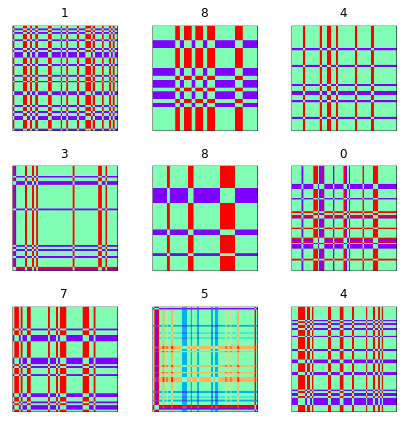

In [8]:
data.show_batch(rows=3, figsize=(6,6))

### Base CNN (ResNet34 + Custom Head)

In [9]:
# Create custom_head
layers = [AdaptiveConcatPool2d(), Flatten(), nn.Linear(1024,10)]
head = nn.Sequential(*layers)

In [10]:
learner = cnn_learner(data, 
                      models.resnet34, 
                      pretrained=True,
                      custom_head=head,
                      metrics=[error_rate, accuracy]).to_fp16()
learner.model[1]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): Linear(in_features=1024, out_features=10, bias=True)
)

### Finding the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 2.66E-03


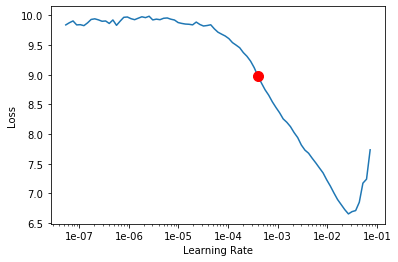

In [11]:
learner.lr_find(start_lr=1e-08,end_lr=0.2, num_it=100)
learner.recorder.plot(suggestion=True)

In [12]:
mingradlr = learner.recorder.min_grad_lr
print(mingradlr)

0.00039778545329620835


### Training the leraner

In [13]:
lr = mingradlr
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,9.694429,6.103289,0.929293,0.070707,00:07
1,8.951289,5.615649,0.929293,0.070707,00:06
2,7.658886,5.517392,0.929293,0.070707,00:06
3,6.520837,4.522911,0.898990,0.101010,00:07
4,5.698449,3.707308,0.848485,0.151515,00:06
5,5.068553,3.621836,0.878788,0.121212,00:07
6,4.561719,3.672032,0.858586,0.141414,00:06
7,4.169548,3.668895,0.848485,0.151515,00:06
8,3.845450,3.641293,0.838384,0.161616,00:06
9,3.592485,3.638696,0.838384,0.161616,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.78E-05
Min loss divided by 10: 2.53E-04


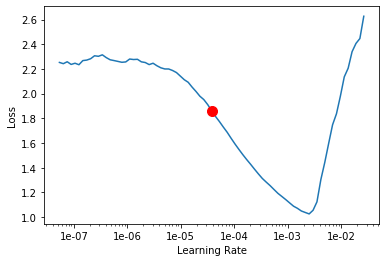

In [14]:
learner.unfreeze()
learner.lr_find(start_lr=1e-08,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [15]:
mingradlr1 = learner.recorder.min_grad_lr
print(mingradlr1)

3.780112263245631e-05


### Differential learning

In [16]:
# Differential learning 
learner.fit_one_cycle(7, slice(mingradlr1, mingradlr1/20))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.252555,3.631044,0.828283,0.171717,00:07
1,2.122249,3.595392,0.818182,0.181818,00:07
2,1.836908,3.523581,0.797980,0.202020,00:07
3,1.545335,3.488958,0.808081,0.191919,00:07
4,1.287155,3.504508,0.838384,0.161616,00:07
5,1.090127,3.519738,0.848485,0.151515,00:07
6,0.945871,3.523243,0.848485,0.151515,00:07


### Results

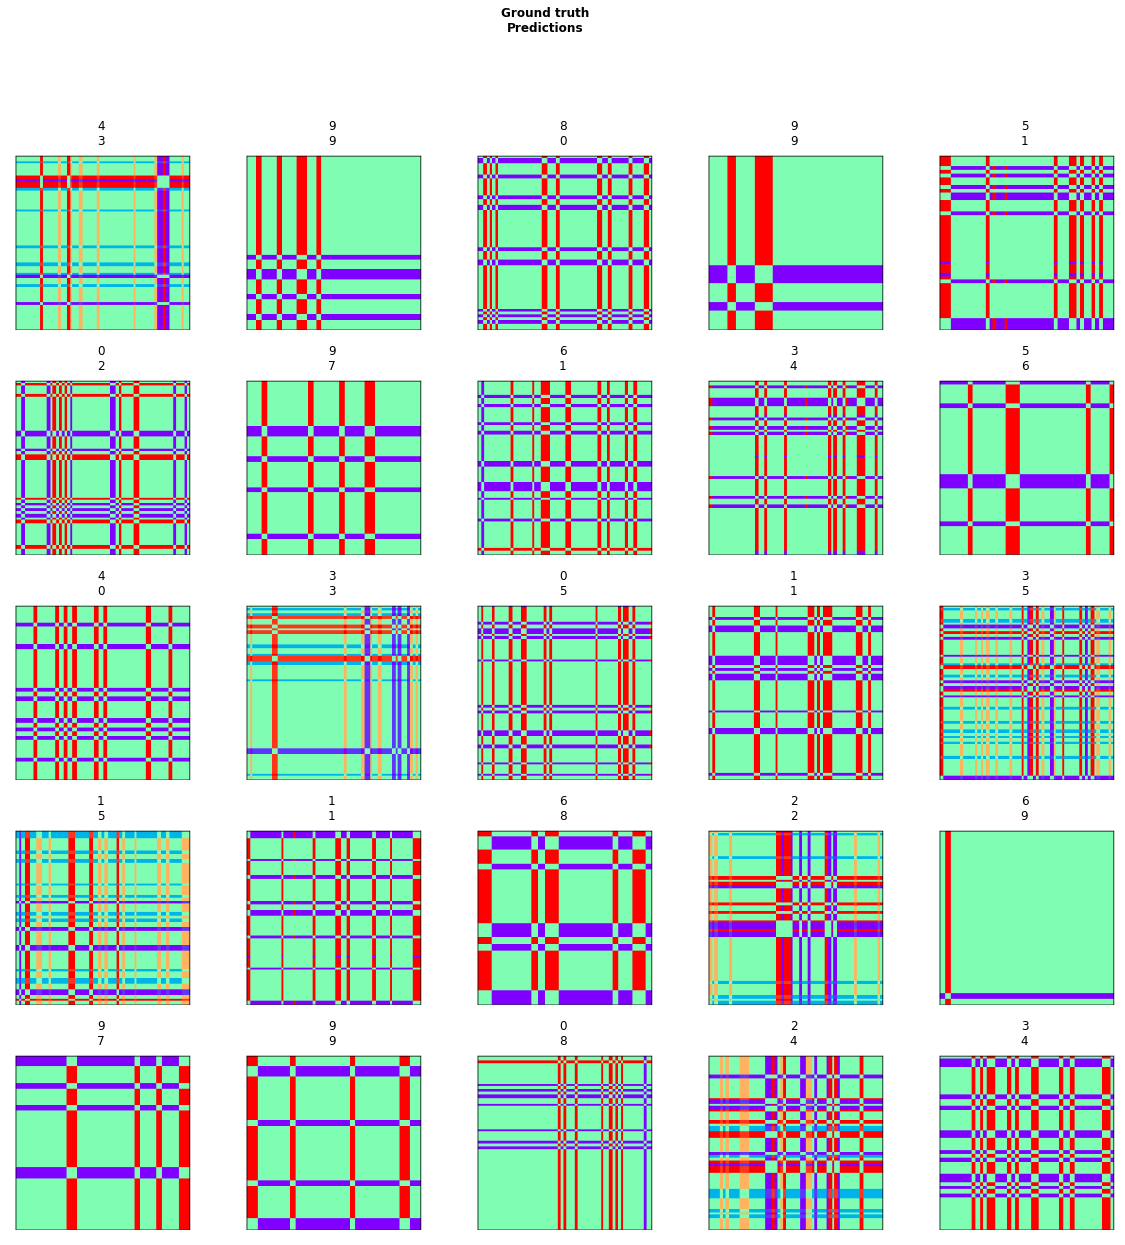

In [17]:
learner.show_results()

### Save